## Core Radius Prediction 

-  **Modeling Mars' Internal Structure** :  The code defines constants and functions to model the internal structure of Mars, calculating properties like temperature, seismic velocities, and phase fractions across different radial layers (core, mantle, crust). It uses these calculations to simulate the planet's physical characteristics based on depth and layer-specific parameters.
- **P wave aand S waves velocity** : Calculated the theoretical values of P and S waves velocities and density and compared them with the benchmark models.
- **Machine Learning to predict Core Radius** : Fitted Random Forest Regressor on the benchmark datasets and predicted the core radius on our modelling of the Martian Interior and compared the predicted and the theoretical values. 

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from obspy.taup import TauPyModel
import matplotlib.lines as mlines
import glob
from sklearn.model_selection import train_test_split
import torch

In [3]:
RADIUS_MARS = 3389500  # Mars radius in meters
LAYERS = 100  # Number of radial layers
CORE_RADIUS = 1700000  # Core radius in meters
CRUST_THICKNESS = 50000  # Crust thickness in meters
T_SURFACE = 220  # Surface temperature in Kelvin
T_CORE = 1900  # Core temperature in Kelvin
PHASE_TRANSITION_COEFFS = {
    "olivine-spinel": [0.0035, 0.0023, 0.0003],
    "wadsleyite-ringwoodite": [0.0025, 0.0018, 0.0002],
    "ringwoodite-perovskite": [0.0015, 0.0012, 0.0001]
}
MODULI_PARAMS = {
    "core": {"K": 150e9, "mu": 50e9, "rho": 7200},
    "mantle": {"K": 100e9, "mu": 40e9, "rho": 3700},
    "crust": {"K": 80e9, "mu": 30e9, "rho": 3200}
}

def thermal_profile(r, T_surface, T_core, R):
    return T_surface + (T_core - T_surface) * (r / R) ** 0.7 

def seismic_velocities(rho, K, mu, is_liquid=False):
    vp = np.sqrt((K + 4/3 * mu) / rho)
    vs = 0 if is_liquid else np.sqrt(mu / rho)
    return vp, vs

def compute_phase_fraction(P, T, coeffs):
    return coeffs[0] * P - coeffs[1] * T + coeffs[2]

def shear_quality_factor(depth):
    return 100 + 0.2 * depth  

def generate():
    results = []
    for r in np.linspace(0, RADIUS_MARS, LAYERS):
        depth = (RADIUS_MARS - r) / 1000  

        if r <= CORE_RADIUS:
            layer = "core"
            P = 15  # Pressure in GPa (approximate)
            is_liquid = True
        elif r <= CORE_RADIUS + CRUST_THICKNESS:
            layer = "crust"
            P = 5  # Pressure in GPa (approximate)
            is_liquid = False
        else:
            layer = "mantle"
            P = 10  # Pressure in GPa (approximate)
            is_liquid = False

        params = MODULI_PARAMS[layer]
        rho = params["rho"]
        K = params["K"]
        mu = params["mu"]
        T = thermal_profile(r, T_SURFACE, T_CORE, RADIUS_MARS)
        vp, vs = seismic_velocities(rho, K, mu, is_liquid)
        Q_mu = shear_quality_factor(depth)
        vpv = vp  
        vph = vp 
        vsv = vs 
        vsh = vs 
        qka = 57822.0 
        eta = 1.0

        results.append([r, rho, vpv, vsv, qka, Q_mu, vph, vsh, eta])

    columns = ["radius", "rho", "vpv", "vsv", "qka", "qmu", "vph", "vsh", "eta"]
    return pd.DataFrame(results, columns=columns)

refined_df = generate()
refined_df.to_csv(r"module_7_data/THARAK_MODEL.csv", index=False, float_format="%.5f")

- Our own model of P and S waves velocity and Density calculated by assuming the values of constants and parameter form references and previous research works.  

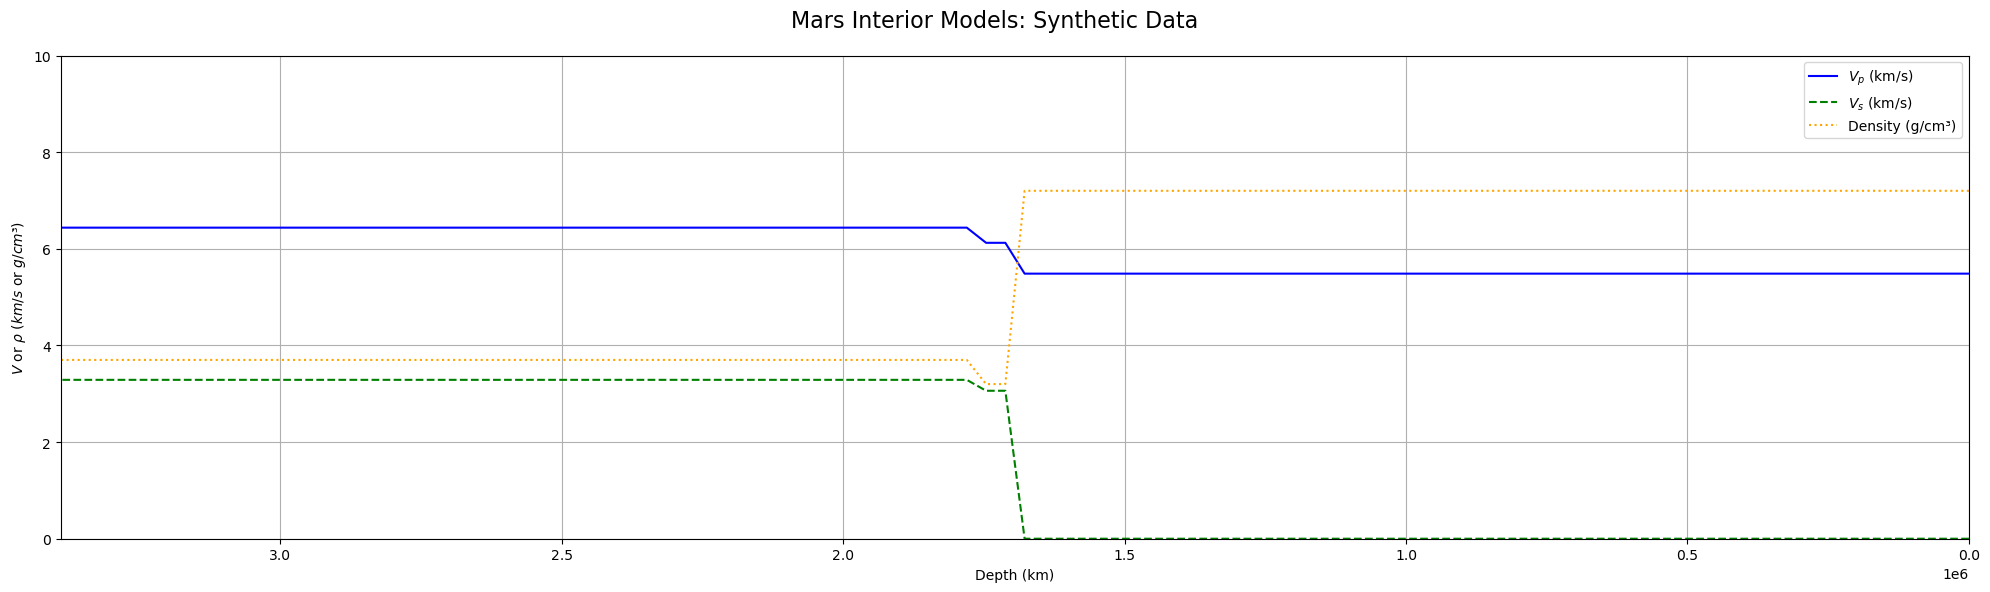

In [4]:
df = pd.read_csv(r"module_7_data/THARAK_MODEL.csv")

plt.figure(figsize=(20, 6))
plt.plot( df['radius'],df['vpv'] / 1000, label='$V_p$ (km/s)', color='blue', linewidth = 1.5)
plt.plot( df['radius'],df['vsv'] / 1000, label='$V_s$ (km/s)', linestyle='dashed', color='green', linewidth = 1.5)
plt.plot( df['radius'],df['rho'] / 1000,  label='Density (g/cm³)', linestyle='dotted', color='orange', linewidth = 1.5)
plt.ylabel('$V$ or $\\rho$ ($km/s$ or $g/cm³$)')
plt.xlabel('Depth (km)')
plt.xlim(df['radius'].max(), 0)
plt.ylim(0, 10)
plt.legend()
plt.grid(True)
plt.suptitle("Mars Interior Models: Synthetic Data", fontsize=16)
plt.tight_layout()
plt.show()

- The benchmark models. 

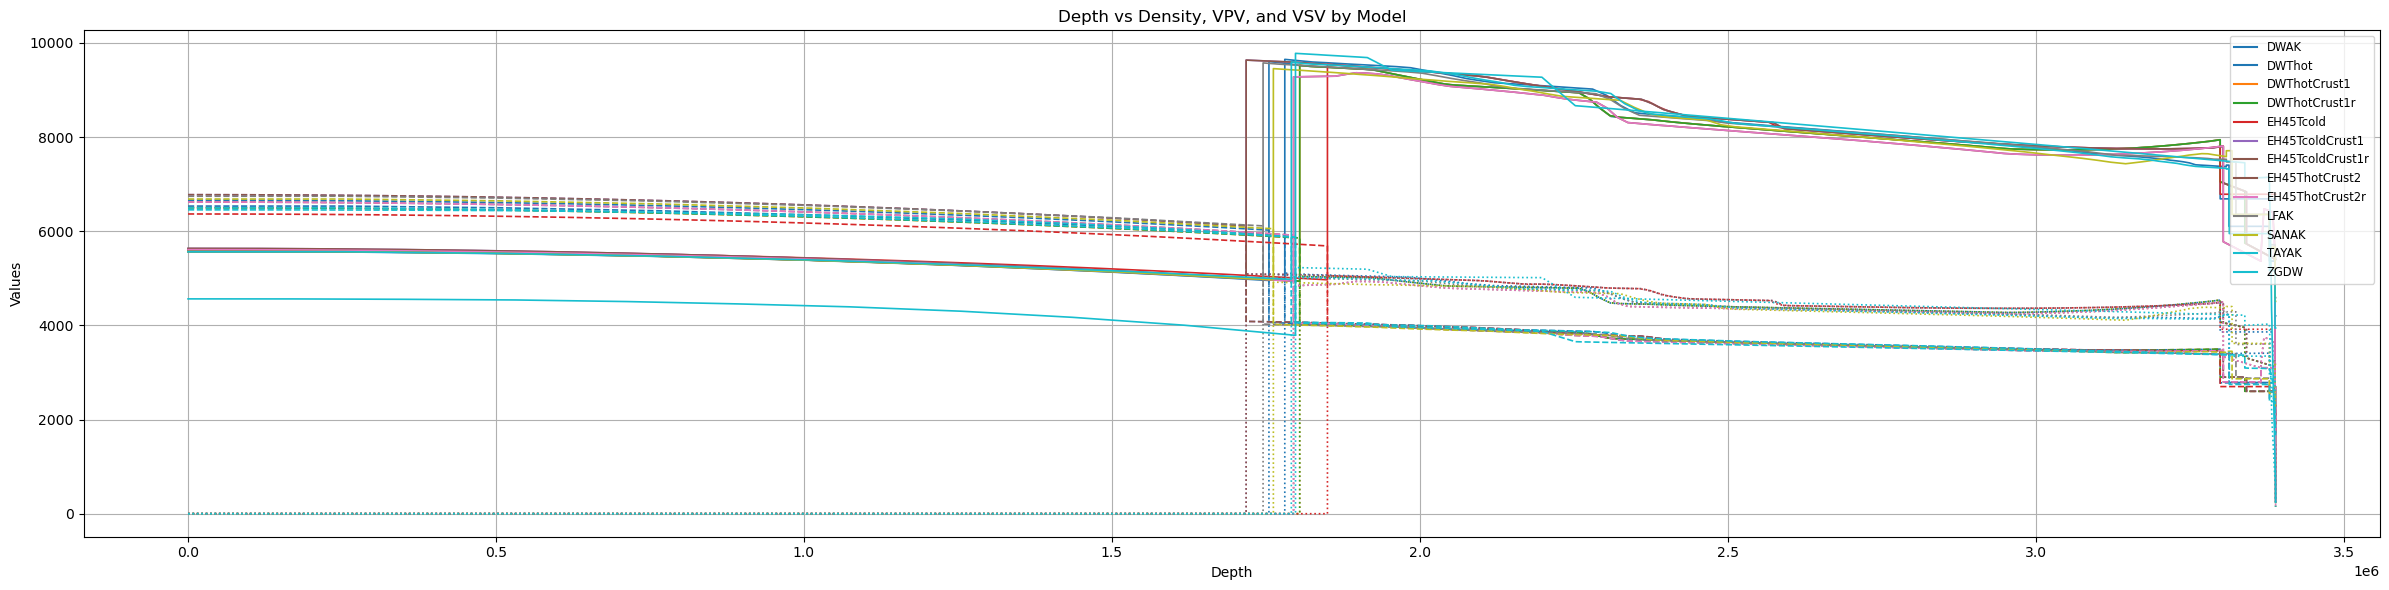

In [5]:
def process_bm_files(directory_path):
    bm_files = glob.glob(os.path.join(directory_path, "*.bm"))
    data = []

    for file in bm_files:
        model_name = os.path.basename(file).split(".")[0]
        with open(file, "r") as f:
            lines = f.readlines()
        columns_start = False
        for line in lines:
            if line.strip().startswith("COLUMNS"):
                columns_start = True
                continue
            if columns_start:
                try:
                    parts = line.split()
                    depth = float(parts[0])
                    rho = float(parts[1])
                    vpv = float(parts[2])
                    vsv = float(parts[3])
                    data.append([model_name, depth, rho, vpv, vsv])
                except (IndexError, ValueError):
                    continue
    df = pd.DataFrame(data, columns=["Model", "Depth", "Density", "VPV", "VSV"])
    return df

def calculate_core_radius(df):
    core_radii = {}
    for model, group in df.groupby("Model"):
        non_zero_vsv = group[group["VSV"] > 0]
        if not non_zero_vsv.empty:
            core_radius = non_zero_vsv.iloc[0]["Depth"]
        else:
            core_radius = np.nan
        core_radii[model] = core_radius
    return core_radii

directory_path = r"module_7_data\BM FILES"
bm_data = process_bm_files(directory_path)
core_radius_dict = calculate_core_radius(bm_data)
bm_data["CoreRadius"] = bm_data["Model"].map(core_radius_dict)
bm_data = bm_data.dropna(subset=["CoreRadius"])

fig, ax = plt.subplots(figsize=(24, 6))
models = bm_data["Model"].unique()
colors = plt.cm.tab10(torch.linspace(0, 1, len(models)).numpy())

line_styles = {"Density": "--", "VPV": "-", "VSV": ":"}
for model, color in zip(models, colors):
    group = bm_data[bm_data["Model"] == model]
    for feature, style in line_styles.items():
        ax.plot(torch.tensor(group["Depth"].values), torch.tensor(group[feature].values), linestyle=style, color=color, linewidth=1.2)
for model, color in zip(models, colors):
    ax.plot([], [], color=color, label=model)

ax.set_xlabel("Depth")
ax.set_ylabel("Values")
ax.set_title("Depth vs Density, VPV, and VSV by Model")
ax.legend(loc="upper right", fontsize="small")
ax.grid()
plt.tight_layout()
plt.show()

#### Machine Learning : 

- Fitted Random forest regressor on P wave velocity, S wave velocity and Density to predict the core radius .
- Comparision between the actual and predicted values in also shown in the plot below. 

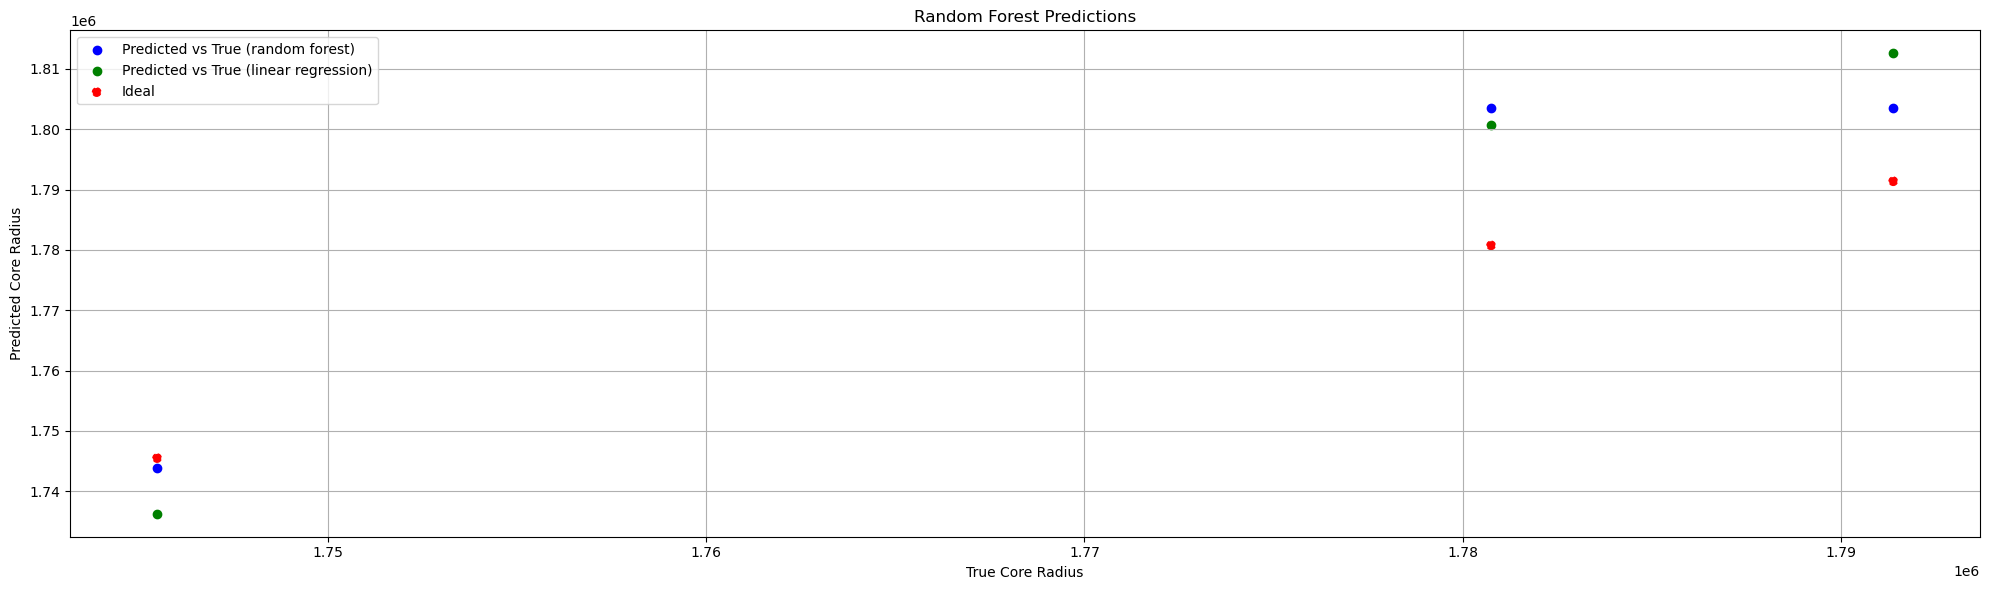

In [6]:
def process_bm_files(directory_path):
    bm_files = glob.glob(os.path.join(directory_path, "*.bm"))
    data = []

    for file in bm_files:
        model_name = os.path.basename(file).split(".")[0]
        with open(file, "r") as f:
            lines = f.readlines()
        columns_start = False
        for line in lines:
            if line.strip().startswith("COLUMNS"):
                columns_start = True
                continue
            if columns_start:
                try:
                    parts = line.split()
                    depth = float(parts[0])
                    rho = float(parts[1])
                    vpv = float(parts[2])
                    vsv = float(parts[3])
                    data.append([model_name, depth, rho, vpv, vsv])
                except (IndexError, ValueError):
                    continue
    df = pd.DataFrame(data, columns=["Model", "Depth", "Density", "VPV", "VSV"])
    return df

def calculate_core_radius(df):
    core_radii = {}
    for model, group in df.groupby("Model"):
        non_zero_vsv = group[group["VSV"] > 0]
        if not non_zero_vsv.empty:
            core_radius = non_zero_vsv.iloc[0]["Depth"]
        else:
            core_radius = np.nan
        core_radii[model] = core_radius
    return core_radii

directory_path = r"module_7_data\BM FILES"
bm_data = process_bm_files(directory_path)
core_radius_dict = calculate_core_radius(bm_data)
bm_data["CoreRadius"] = bm_data["Model"].map(core_radius_dict)
bm_data = bm_data.dropna(subset=["CoreRadius"])

bm_grouped = bm_data.groupby("Model").first().reset_index()
X = bm_grouped[["Density", "VPV", "VSV"]]
y = bm_grouped["CoreRadius"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=512, random_state=256)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)

plt.figure(figsize=(20, 6))
plt.scatter(y_test, y_pred_rf, color="blue", label="Predicted vs True (random forest)")
plt.scatter(y_test, y_pred_lr, color="green", label="Predicted vs True (linear regression)")
plt.scatter(y_test, y_test, color="red", linestyle="--", label="Ideal")
plt.xlabel("True Core Radius")
plt.ylabel("Predicted Core Radius")
plt.title("Random Forest Predictions")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [8]:
warnings.filterwarnings("ignore", category=UserWarning)
def process_csv_file(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns={
        "rho": "Density",
        "vpv": "VPV",
        "vsv": "VSV",
        "radius": "radius"
    }, inplace=True)
    return df

def calculate_core_radius(df):
    non_zero_vs = df[df["VSV"] > 0]
    if not non_zero_vs.empty:
        core_radius = non_zero_vs.iloc[0]["radius"]
    else:
        core_radius = np.nan
    return core_radius

file_path = "module_7_data/THARAK_MODEL.csv"
data = process_csv_file(file_path)

core_radius = calculate_core_radius(data)
data = data.drop(columns=["radius"])
data = data.dropna()

X = data[["Density", "VPV", "VSV"]]
y = core_radius

y_pred_rf = rf_model.predict(X)
y_pred_lr = linear_model.predict(X)

print(f"True Core Radius: {y} m")
print(f"Predicted Core Radius (random forest): {y_pred_rf[0]} m")
print(f"Predicted Core Radius (linear regression): {y_pred_lr[0]} m")
mae = mean_absolute_error([y], [y_pred_rf[0]])
print(f"Mean Absolute Error: {mae:.2f}")

True Core Radius: 1711868.68687 m
Predicted Core Radius (random forest): 1743782.5281250053 m
Predicted Core Radius (linear regression): 1592758.235082625 m
Mean Absolute Error: 31913.84


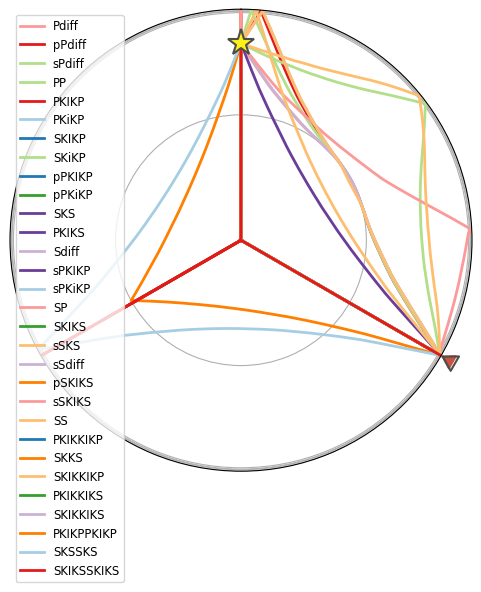

In [9]:
model = TauPyModel(model=r"module_7_data/Geophysical_model.npz")
SOURCE = 500 
EPICENTRE = 120 

arrivals = model.get_travel_times(source_depth_in_km=SOURCE, distance_in_degree=EPICENTRE)
phases = list(dict.fromkeys([arrival.name for arrival in arrivals]))
color_map = {phase: plt.cm.tab10(i % 10) for i, phase in enumerate(phases)}
ray_paths = model.get_ray_paths(source_depth_in_km=SOURCE, distance_in_degree=EPICENTRE)
fig_ray_paths = ray_paths.plot_rays(plot_type="spherical", fig=plt.figure(figsize=(6, 6)), phase_list=color_map.keys(), legend=True)

legend_handles = [
    mlines.Line2D([], [], color=color_map[phase], marker='o', linestyle='None', markersize=8, label=phase)
    for phase in phases
]